In [1]:
%pylab inline
import numpy as np
from tqdm import trange
import torch
from torchvision import datasets, transforms
np.set_printoptions(suppress=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Define a transform to convert to tensor (we'll normalize later)
transform = transforms.ToTensor()

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert to numpy arrays
X_train = train_dataset.data.numpy()
Y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
Y_test = test_dataset.targets.numpy()

# Reshape and normalize
X_train = X_train.reshape(-1, 28, 28).astype(np.float32) / 255.0
X_test = X_test.reshape(-1, 28, 28).astype(np.float32) / 255.0



In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
# attempt to autodetect device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

using device: mps


In [5]:
class SeanNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784,128)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(128,10)
        self.sm = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x
model = SeanNet()
model.to(device)

SeanNet(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (sm): LogSoftmax(dim=1)
)

In [6]:
criterion = nn.CrossEntropyLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

In [7]:
import matplotlib.pyplot as plt

loss 0.66 accuracy 0.82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 476.22it/s]


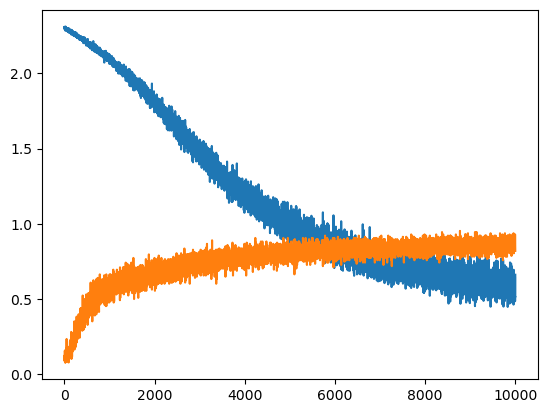

In [8]:
losses, accuracies = [], []
BS = 128
for i in (t := trange(10000)):
    optim.zero_grad()
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    X = X.to(device)
    Y = torch.tensor(Y_train[samp]).long()
    Y = Y.to(device)

    preds = model(X)
    loss = criterion(preds, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    cat = torch.argmax(preds, dim=1)
    #print("Cat: {} Y: {}".format(cat, Y))
    accuracy = (cat == Y).float().mean()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)

    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
#plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [9]:
X = torch.tensor(X_test.reshape((-1, 28*28))).float()
X = X.to(device)
Y = torch.tensor(Y_test).long()
Y = Y.to(device)
preds = model(X)
loss = criterion(preds, Y)
loss = loss.mean()
loss.backward()
optim.step()
cat = torch.argmax(preds, dim=1)
accuracy = (cat == Y).float().mean()
loss, accuracy = loss.item(), accuracy.item()
print("loss {} accuracy {}".format(loss, accuracy))

loss 0.5605424642562866 accuracy 0.8675999641418457
